In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils import data
def prepare_data():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

    root_dir = "./data/train";
    train_set = datasets.ImageFolder(root = root_dir,
                transform = transforms.ToTensor())

    trainloader = data.DataLoader(train_set, batch_size = 4, shuffle = True)

    root_dir = "./data/test";
    train_set = datasets.ImageFolder(root = root_dir,
                transform = transforms.ToTensor())

    testloader = data.DataLoader(train_set, batch_size = 4, shuffle = True)
    classes = ('Natalie Portman', 'Julia Roberts', 'Neil Patrick Harris'
                    , 'Keifer Sutherland', 'Ben Stiller', 'Anne Hathaway'
                    , 'David Boreanaz', 'Jamie Foxx', 'Sofia Vergara'
                    , 'Elizabeth Banks', 'Jensen Ackles', 'Amy Adams'
                    , 'Kristen Bell', 'Bradley Cooper', 'Emily Deschanel'
                    , 'Zooey Deschanel', 'Jon Hamm', 'Scarlett Johansson'
                    , 'Blake Lively', 'Eva Longoria', 'Amy Poehler'
                    , 'Kristen Stewart', 'Kerry Washington', 'Leighton Meester'
                    , 'Olivia Wilde', 'Zac Efron', 'Miley Cyrus','Jim Parsons')
    return trainloader, testloader, classes

#
# print("train size: " + str(len(trainloader)))
#
# print("test size: " + str(len(testloader)))

torch.Size([4, 3, 250, 250])
Leighton Meester


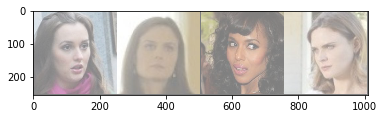

In [4]:
trainloader, testloader, classes = prepare_data()

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

def prepare_and_init_Net(number_layers_1, number_layers_2, number_layers_3):
    class Net(nn.Module):
        def __init__(self, device):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, number_layers_1, 11)
            self.conv2 = nn.Conv2d(number_layers_1, number_layers_2, 9)
            self.conv3 = nn.Conv2d(number_layers_2, number_layers_3, 7)
            self.conv4 = nn.Conv2d(number_layers_3, 40, 6)
            self.pool2 = nn.MaxPool2d(2, 2)
            # self.pool3 = nn.MaxPool2d(3,3)
            self.fc1 = nn.Linear(40 * 10 * 10, 240)       #coś tu się dzieje, nie jestem pewnien co
            self.fc2 = nn.Linear(240, 120)
            self.fc3 = nn.Linear(120, 28)

        def forward(self, x):
            # print(x.shape)
            x = self.pool2(F.relu(self.conv1(x)))
            # print(x.shape)
            x = self.pool2(F.relu(self.conv2(x)))

            x = self.pool2(F.relu(self.conv3(x)))
            x = self.pool2(F.relu(self.conv4(x)))
            # print(x.shape)
            # print("to tu?")
            x = x.view(-1, 40 * 10 * 10)
            # print(x.shape)
            x = F.relu(self.fc1(x))
            # print(x.shape)
            x = F.relu(self.fc2(x))
            # print(x.shape)
            x = self.fc3(x)
            # print(x.shape)
            return x


    net = Net(device='cuda:0')
    return net
# print(net.parameters())

In [6]:
import torch.optim as optim

# net = prepare_and_init_Net()

def crit_and_opt():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    return criterion, optimizer

In [7]:
def cuda_init():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device
# Assuming that we are on a CUDA machine, this should print a CUDA device:


In [8]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
def accuracy(device, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the 2772 test images: %f %%' % (
        100 * correct / total))


In [11]:
def learn(device, trainloader, testloader, optimizer, criterion):
    counter=0
    for epoch in range(10):  # loop over the dataset multiple times


        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)
            # print(inputs.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2500 == 2499:    # print every 2000 mini-batches
                counter += 1
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2500))
                running_loss = 0.0
        accuracy(device, testloader)

    print('Finished Training')

In [10]:
min_first_layer = 6
max_first_layer = 10
min_second_layer = 12
max_second_layer = 18
min_third_layer = 20
max_third_layer = 40

for first_layer in range(min_first_layer, max_first_layer):
    for second_layer in range(min_second_layer, max_second_layer):
        for third_layer in range(min_third_layer, max_third_layer):
            print("first layer: ", first_layer, " second layer: ",
                  second_layer, " third layer: ", third_layer)
            trainloader, testloader, classes = prepare_data()
            device = cuda_init()
            net = prepare_and_init_Net(first_layer, second_layer, third_layer)
            criterion, optimizer = crit_and_opt()
            learn(device, trainloader, testloader, optimizer, criterion)

first layer:  6  second layer:  12  third layer:  20
[1,  2500] loss: 3.334
Accuracy of the network on the 2772 test images: 3.571429 %
[2,  2500] loss: 3.312
Accuracy of the network on the 2772 test images: 11.111111 %
[3,  2500] loss: 2.715
Accuracy of the network on the 2772 test images: 32.972583 %
[4,  2500] loss: 1.901
Accuracy of the network on the 2772 test images: 48.845599 %
[5,  2500] loss: 1.389
Accuracy of the network on the 2772 test images: 57.647908 %
[6,  2500] loss: 1.082
Accuracy of the network on the 2772 test images: 63.600289 %
[7,  2500] loss: 0.853
Accuracy of the network on the 2772 test images: 60.930736 %
[8,  2500] loss: 0.718
Accuracy of the network on the 2772 test images: 64.249639 %
[9,  2500] loss: 0.561
Accuracy of the network on the 2772 test images: 64.790765 %
[10,  2500] loss: 0.568
Accuracy of the network on the 2772 test images: 60.317460 %
Finished Training
first layer:  6  second layer:  12  third layer:  21
[1,  2500] loss: 3.330
Accuracy of t

FileNotFoundError: [Errno 2] No such file or directory: './data/train/0000204/213.jpg'